In [15]:
%matplotlib inline
from matplotlib import gridspec, cm
from plot import bootstrap_samples_mean
from typing import List, Union
import matplotlib.pyplot as plt
import pandas
import numpy as np
import functools
import itertools

## Notes

1. Chose a set of clique size (i.e. 10 / 15 / 20 / 30 or something like that)
2. Aggregate by added (for a missing added) or by added (by a fixed missing)
3. Plot ratio and time, which are the metrics

In [7]:
default_algo = dict(
    find2 = 'Find2',
    findq = 'FindQ',
    findqg = 'FindQ (grow)'
)

In [55]:
def plot_results(raw: pandas.DataFrame, fix:dict, groupby: str, algorithms: dict=default_algo, xlabel: str=None, fig=None, gs=None, title:str=None):
    nsamples = 500
    sm = cm.ScalarMappable(cmap='Dark2', norm=plt.Normalize(vmin=0, vmax=len(algorithms) + 1))
    
    if fig is None:
        fig = plt.figure(figsize=(8, 8))
    
    mask = functools.reduce(lambda a, b: a & b, [raw[k] == v for k, v in fix.items()])
    masked = raw[mask]

    agg_mean = dict()
    agg_std = dict()
    for name, grp in masked.groupby(groupby):
        sample_means = pandas.DataFrame([grp.sample(frac=1, replace=True).mean() for _ in range(nsamples)])
        agg_mean[name] = sample_means.mean()
        agg_std[name] = sample_means.std()
    agg_mean = pandas.DataFrame(agg_mean).T
    agg_std = pandas.DataFrame(agg_std).T
    
    agg_timeout = masked.groupby([groupby]).agg({f'{algo}_time': lambda x: x.isnull().sum() for algo in algorithms}).astype(int)
    
    if gs is None:
        grid = gridspec.GridSpec(ncols=1, nrows=5, hspace=0, figure=fig)
    else:
        grid = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=5, hspace=0, subplot_spec=gs)
       
    # Ratio
    markers = itertools.cycle(['o', 's', 'D'])
    lines = itertools.cycle(['--', '-.', ':'])
    
    ax_ratio = fig.add_subplot(grid[0:2, 0])
    for i, (algo, label) in enumerate(algorithms.items()):
        ax_ratio.errorbar(agg_mean.index, agg_mean[f'{algo}_ratio'], yerr=agg_std[f'{algo}_ratio'],
                          marker=next(markers), linestyle=next(lines),
                          label=label, c=sm.to_rgba(i), capsize=4*(len(algorithms)-i))
    ax_ratio.set_ylabel('Recovery ratio')
    ax_ratio.legend()
    if title:
        ax_ratio.set_title(title)
    
    # Time
    markers = itertools.cycle(['o', 's', 'D'])
    lines = itertools.cycle(['--', '-.', ':'])
    
    ax_time = fig.add_subplot(grid[2:4, 0], sharex=ax_ratio)
    for i, (algo, label) in enumerate(algorithms.items()):
        ax_time.errorbar(agg_mean.index, agg_mean[f'{algo}_time'], yerr=agg_std[f'{algo}_time'],
                          marker=next(markers), linestyle=next(lines),
                          label=label, c=sm.to_rgba(i), capsize=4*(len(algorithms)-i))
    ax_time.set_ylabel('Time')
    
    # Timeouts
    if len(agg_mean.index) > 2:
        bar_width = (agg_mean.index[-1] - agg_mean.index[-2])/2.
    else:
        bar_width = 0.01
    
    ax_timeout = fig.add_subplot(grid[4, 0], sharex=ax_ratio)
    bottom = np.zeros(len(agg_timeout.index))
    for i, (algo, label) in enumerate(algorithms.items()):
        ax_timeout.bar(agg_timeout.index, agg_timeout[f'{algo}_time'], bottom=bottom,
                       width=bar_width, label=label, color=sm.to_rgba(i))
        bottom += agg_timeout[f'{algo}_time']

    ax_timeout.set_ylabel('Timeouts')
    ax_timeout.set_xlabel(xlabel)
    ax_timeout.set_xticks(agg_mean.index)
    
    return fig


In [30]:
raw2_results = pandas.read_csv('../results/quasi2.csv', index_col=0)
raw3_results = pandas.read_csv('../results/quasi3.csv', index_col=0)
raw4_results = pandas.read_csv('../results/quasi4.csv', index_col=0)

/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


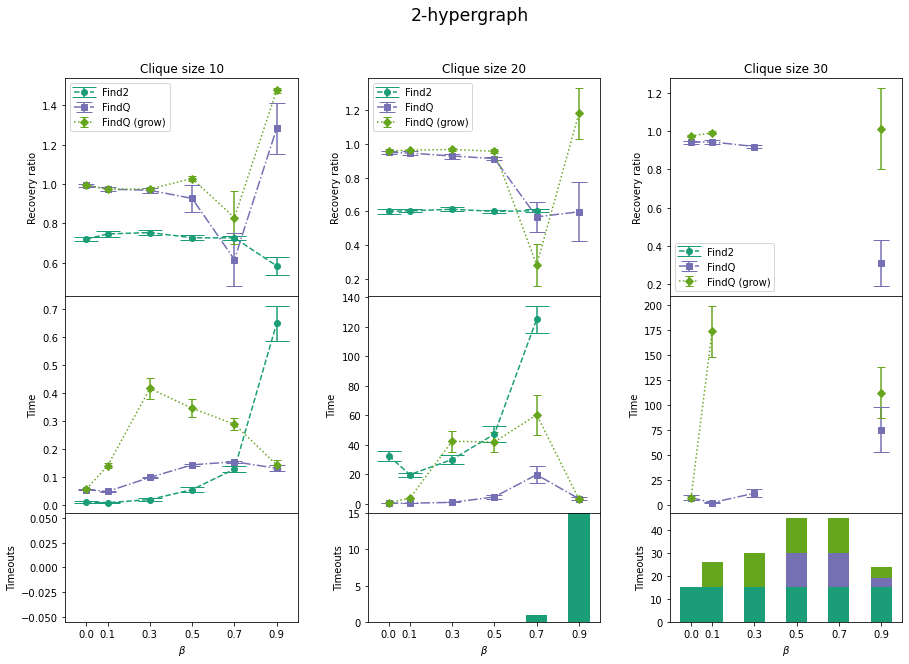

In [50]:
fig = plt.figure(figsize=(15, 10))
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(raw2_results, dict(missing=0.1, clique=10), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[0], title='Clique size 10')
plot_results(raw2_results, dict(missing=0.1, clique=20), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[1], title='Clique size 20')
plot_results(raw2_results, dict(missing=0.1, clique=30), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[2], title='Clique size 30')
fig.suptitle('2-hypergraph', fontsize='xx-large')

plt.show()

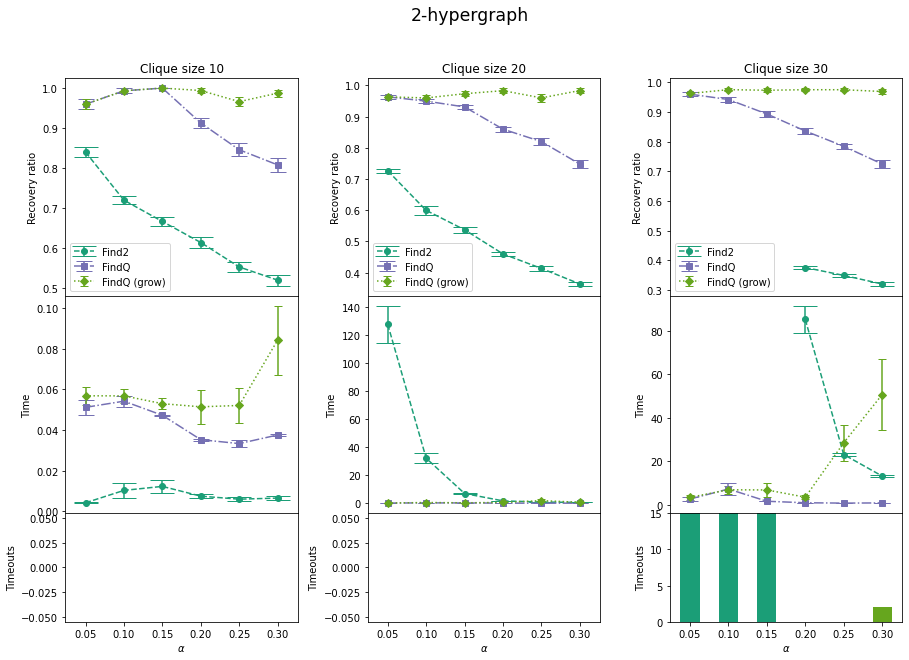

In [51]:
fig = plt.figure(figsize=(15, 10))
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(raw2_results, dict(added=0.0, clique=10), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='Clique size 10')
plot_results(raw2_results, dict(added=0.0, clique=20), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='Clique size 20')
plot_results(raw2_results, dict(added=0.0, clique=30), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='Clique size 30')
fig.suptitle('2-hypergraph', fontsize='xx-large')

plt.show()

/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


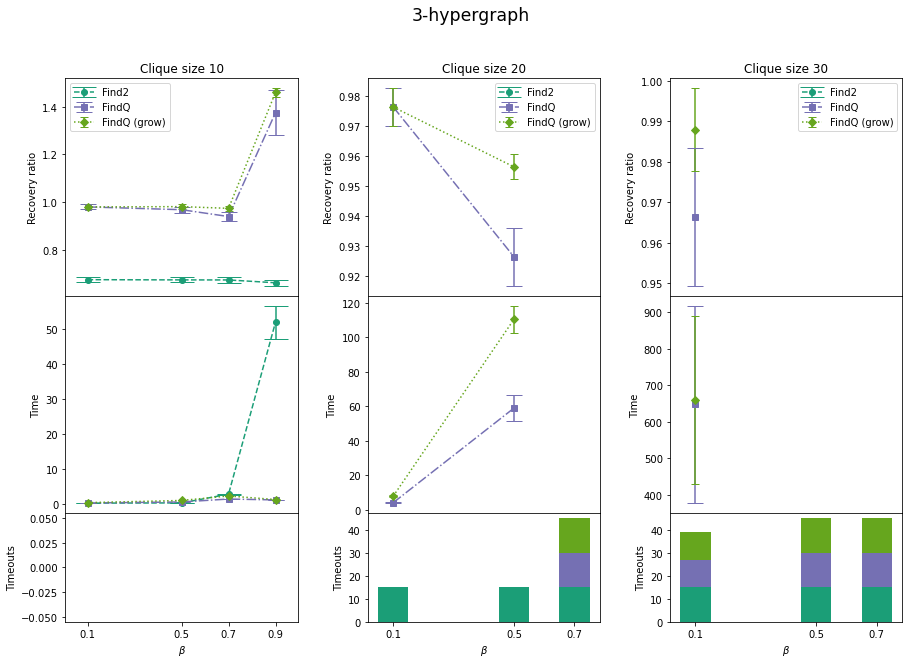

In [52]:
fig = plt.figure(figsize=(15, 10))
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(raw3_results, dict(missing=0.1, clique=10), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[0], title='Clique size 10')
plot_results(raw3_results, dict(missing=0.1, clique=20), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[1], title='Clique size 20')
plot_results(raw3_results, dict(missing=0.1, clique=30), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[2], title='Clique size 30')
fig.suptitle('3-hypergraph', fontsize='xx-large')

plt.show()

/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


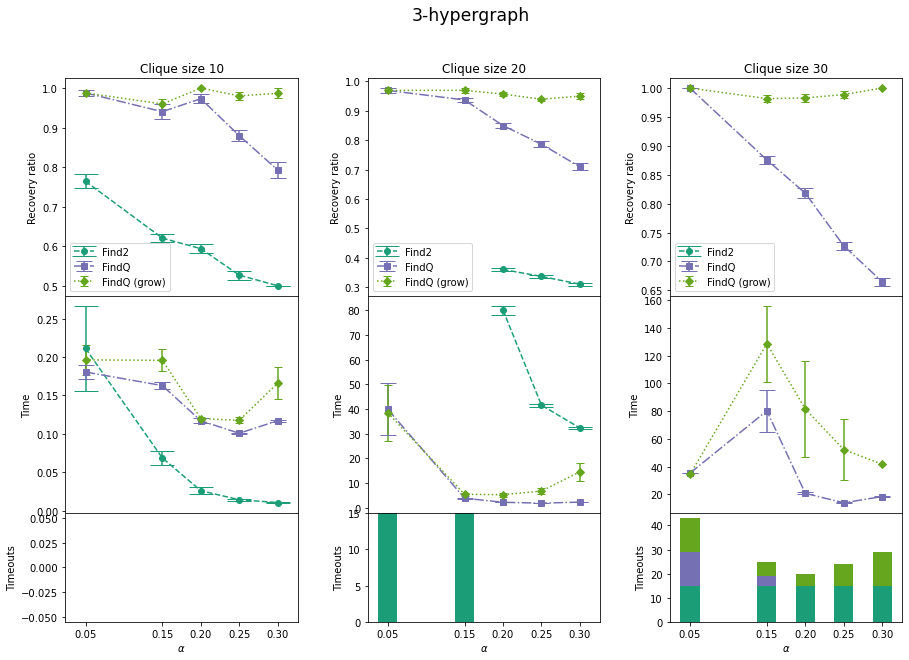

In [53]:
fig = plt.figure(figsize=(15, 10))
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(raw3_results, dict(added=0.0, clique=10), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='Clique size 10')
plot_results(raw3_results, dict(added=0.0, clique=20), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='Clique size 20')
plot_results(raw3_results, dict(added=0.0, clique=30), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='Clique size 30')
fig.suptitle('3-hypergraph', fontsize='xx-large')

fig.savefig('/home/aalvarez/Downloads/3hyper.eps')
plt.show()

/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan

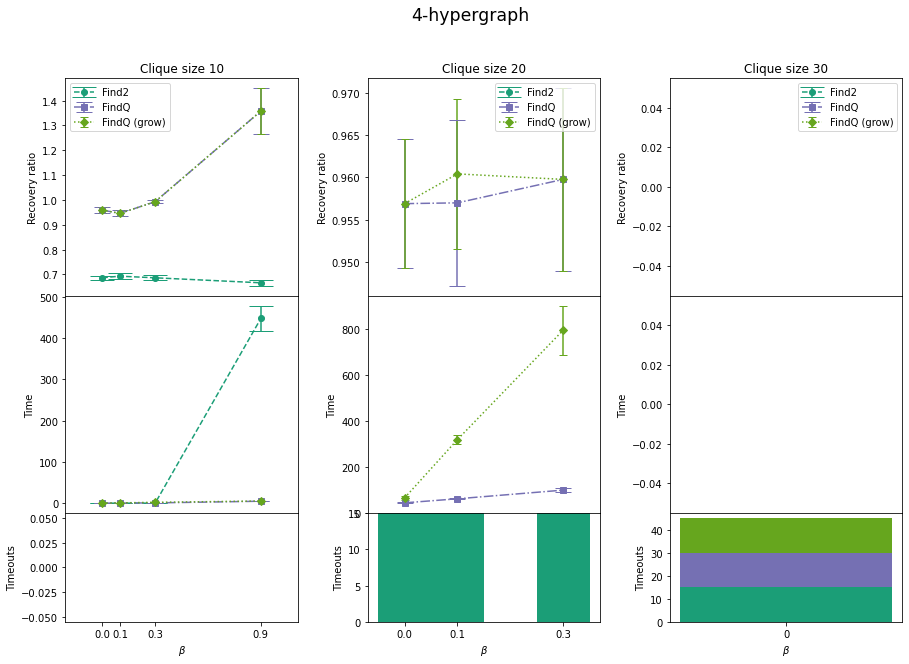

In [56]:
fig = plt.figure(figsize=(15, 10))
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(raw4_results, dict(missing=0.1, clique=10), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[0], title='Clique size 10')
plot_results(raw4_results, dict(missing=0.1, clique=20), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[1], title='Clique size 20')
plot_results(raw4_results, dict(missing=0.1, clique=30), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[2], title='Clique size 30')
fig.suptitle('4-hypergraph', fontsize='xx-large')

plt.show()

/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


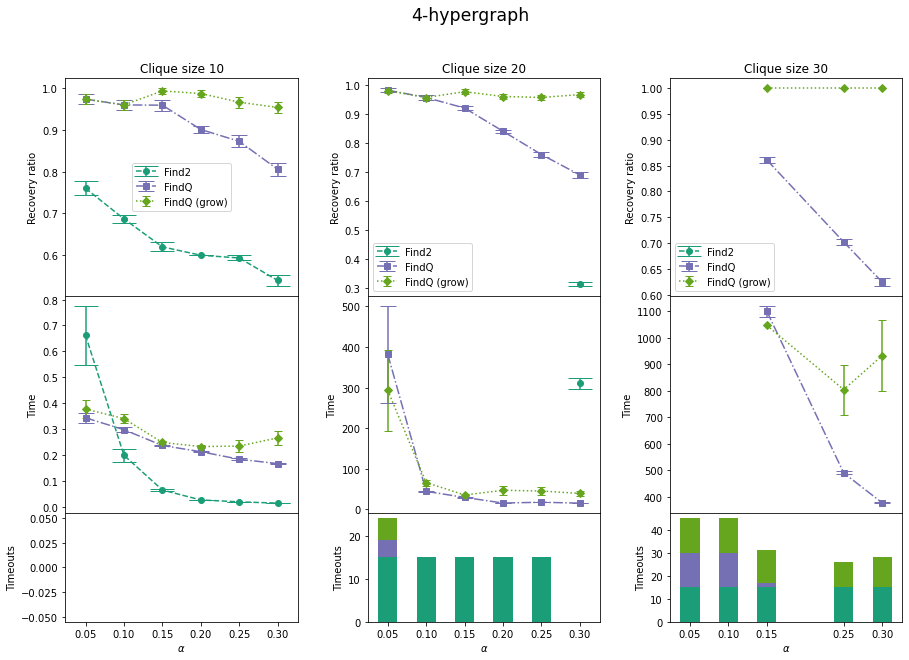

In [57]:
fig = plt.figure(figsize=(15, 10))
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(raw4_results, dict(added=0.0, clique=10), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='Clique size 10')
plot_results(raw4_results, dict(added=0.0, clique=20), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='Clique size 20')
plot_results(raw4_results, dict(added=0.0, clique=30), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='Clique size 30')
fig.suptitle('4-hypergraph', fontsize='xx-large')

fig.savefig('/home/aalvarez/Downloads/4hyper.eps')
plt.show()